강의_6기_AI응용_4차시_03_optical_flow

Optical Flow
- 연속된 두 프레임 사이의 픽셀 이동을 추적하는 방법
- 물체 속도방향
- 자율주행, 드론, 동작인식

In [1]:
import numpy as np
import cv2
# from google.colab.patches import cv2_imshow # Colab 환경에서 이미지 표시를 위한 함수 임포트
import time # 출력 속도를 조절하기 위한 time 모듈 임포트

# --- 1. 초기 설정 및 변수 정의 ---
# NOTE: Colab에서 이 코드를 실행하기 전에, 'newyork.mp4' 파일을 Colab 환경에 업로드해야 합니다.
video_path = 'newyork.mp4'
cap = cv2.VideoCapture(video_path) # 비디오 캡처 객체 생성

# 비디오 파일이 제대로 열렸는지 확인
if not cap.isOpened():
    print("오류: 비디오 파일을 열 수 없습니다. 파일을 업로드했는지 확인하세요.")
    exit()

In [2]:
# 프레임 재생 속도 조절을 위한 딜레이 (1000ms / 30fps = 약 33ms) 1000ms 는 1초
# Colab에서는 실시간 딜레이 대신 time.sleep()으로 대체되지만, 변수는 주석을 위해 유지합니다.
delay = int(1000/30)
# real-time 영상에서 부드러운 재생을 원하기 때문에 필요한 타이밍

# 추적경로 그리기 위한 랜덤색상(200개 코너점 대응 색상)
# randn 하면 안 됨
color = np.random.randint(0, 255, (200, 3)) # 0-255 사이에 3개 채널 색상 200개 생성

lines = None # 추적선(이동경로) 그릴 이미지 저장변수(초기화 : 첫 프레임) 
prevImg = None # previous frame 저장변수(grayscale image)

# calcOpticalFlowPyrLK() 중지 요건 설정 (Termination Criteria)
# (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 최대 반복 횟수(10), 오차 임계값(0.03))
# cv2.TERM_CRITERIA_EPS >> 움직임 0.03 px 미만이면 수렴 >> error 오차가 충분히 작아지면 멈춤
# cv2.TERM_CRITERIA_COUNT >> 최대 반복(iteration) 횟수 10회
termcriteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03) # | 표시 pandas or
# termcriteria -> (3, 10, 0.03)
# 출력 : True에 해당하는 값만 출력

# 루카스-카나델 광학흐름 : 물체 위치추적
# p1, st, err = cv2.calcOpticalFlowPyrLK(old_gray, gray, # 이전 프레임, 현재 프레임
#                                       p0, # 추적할 코너점 좌표(position)
#                                       None, # 기본설정
#                                       winSize=(15,15), # 추적할 윈도우 크기(주변 15*15 영역 비교하여 이동방향 계산)
#                                       maxLevel=2, # 이미지 피라미드 레벨 (영상 축소단계 수)
#                                       criteria=termcriteria) # 중지 요건
# p1 >> 좌표 position
# st >> 성공실패 status. 1이면 성공
# err >> 오차 error. 0.01이면 오차 거의없음 (기준 0.03 미만)

frame_count = 0
MAX_FRAMES_TO_PROCESS = 100
DISPLAY_EVERY_N_FRAMES = 20

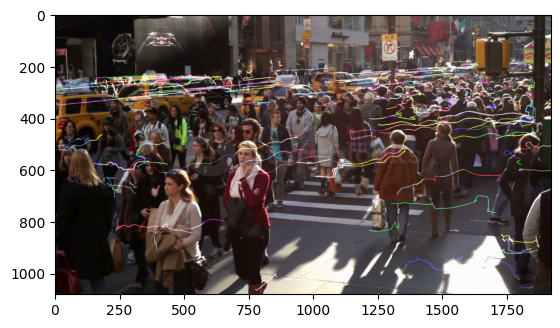

In [3]:
# 비디오 처리
import matplotlib.pyplot as plt
from IPython.display import clear_output


while cap.isOpened() and frame_count < MAX_FRAMES_TO_PROCESS:
    ret, frame = cap.read() # 비디오에서 프레임 읽기

    if not ret:  # 프레임을 제대로 읽지 못했으면
       break

    # 현재 프레임 (사진) 복사 >> 추적결과를 그릴 이미지 준비
    img_draw = frame.copy()
    # optical flow 계산 위해 현재 프레임(사진)을 grayscale 로 변환
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # 최초 프레임 처리(추적 시작)
    if prevImg is None:
        prevImg = gray  # 현재 gray 이미지를 '이전 이미지로' 저장
        # 추적선을 그릴 검은색 배경 이미지 생성 (원본 프레임과 동일 크기)
        lines = np.zeros_like(frame)
        # Shi-Tomasi 알고리즘으로 추적 시작할 코너점 200개 검출
        # (이전 이미지, 최대 코너점 수, 품질 임계값(0.01), 최소거리 10)
        prevPt = cv2.goodFeaturesToTrack(prevImg, 200, 0.01, 10)
        # prevPt: 코너 점의 목록
    # 두번째 프레임 이후 처리(추적 진행 중)
    else:
        nextImg = gray # 현재 gray 이미지를 '다음 이미지로' 저장

        nextPt, status, err = cv2.calcOpticalFlowPyrLK(prevImg, nextImg,
                                     prevPt,None, criteria=termcriteria)

        # 추적에 성공한 코너점(status == 1) 선별
        prevMv = prevPt[status==1] # 이전 프레임에서 추적 성공한 점
        nextMv = nextPt[status==1] # 현재 프레임에 대응하는 점

        # 추적 성공한 모든 쌍에 대해서 반복
        for i, (p, n) in enumerate(zip(prevMv, nextMv)):
          #  코너점 좌표 추출(배열 구조 해제)
          px, py = p.ravel()
          nx, ny = n.ravel()

          # 이전 코너(p)와 새로운 코너(n) 사이에 추적선 그리기 (lines 이미지에 누적)
          cv2.line(lines, (int(px), int(py)), (int(nx), int(ny)), color[i % len(color)].tolist(), 2)
          # 시작점: 이전 위치(px, py), 끝점 (nx, ny)
          # color[i % len(color)].tolist() : 코너점 i 에서 할당된 랜덤 색

          # 새로운 코너(n)에 원형 점 그리기(img_draw 이미지에 매 프레임마다 표시)
          cv2.circle(img_draw, (int(nx), int(ny)), 2, color[i % len(color)].tolist(), -1)

        # 누적된 추적선이 그려진 lines 이미지와 현재 프레임(img_draw)을 합성
        # >> 추적 경로가 비디오 프레임 위에 나타나요
        img_draw = cv2.add(img_draw, lines)

        # 다음 루프 위해 현재 프레임(사진)과 코너점 >> 이전 변수로 이동
        prevImg = nextImg

        prevPt =nextMv.reshape(-1, 1, 2)
        # prevPt를 nextMv 형태로 맞춰 줘야 해요.
        # (N, 2) >> (N,1,2)
        # -1 자동계산


        # 원래 좌표 형식 [[x,y],[x,y],[x,y]]  shape (3,2) >>> (N,2)
        # OpenCV optical Flow 함수 입력 [[[x,y]],[[x,y]],[[x,y]]] shape (3,1,2) >> (N, 1, 2)

    # Colab 출력: 특정 간격의 프레임만 표시
    if frame_count % DISPLAY_EVERY_N_FRAMES == 0:
        print(f"\n--- Frame {frame_count} 광학 흐름 결과 ---")
        # cv2.imshow('optical flow',img_draw) # 추적 결과 프레임 표시
        # time.sleep(1) # 출력이 빠르게 지나가는 것을 방지하기 위해 잠시 대기

    # ... (반복문 내부) ...

        # 1. 색상 변환 (OpenCV는 BGR, plt는 RGB를 씀)
        img_rgb = cv2.cvtColor(img_draw, cv2.COLOR_BGR2RGB)

        # 2. 출력 화면 지우기 (이전 프레임 삭제)
        clear_output(wait=True)

        # 3. 이미지 출력
        plt.imshow(img_rgb)
        plt.show()
        
        # (주의) plt 방식은 cv2.imshow보다 속도가 많이 느려서 영상이 끊겨 보일 수 있습니다.


        if cv2.waitKey(delay) == 27: 
                break

    # 키 입력 처리 (원본 코드에 있던 부분. Colab에서는 작동하지 않으므로,
    # 프레임 수 제한으로 대체하며 주석 처리만 해둡니다.)
    # key = cv2.waitKey(delay)
    # if key == 27:    # ESC 키 (ASCII 27): 루프 종료
    #     break
    # elif key == 8:  # Backspace 키 (ASCII 8): 추적 이력 지우기
    #     prevImg = None

    # ... (기존 코드: img_draw 합성 부분) ...
        img_draw = cv2.add(img_draw, lines)

        # [추가할 코드] 현재 화면을 파일로 저장
        cv2.imwrite('optical.png', img_draw) 

    # ... (기존 코드: 다음 루프 준비) ...


    frame_count += 1

# --- 3. 종료 및 정리 (수정 완료) ---
# 모든 OpenCV 창 닫기 (Colab에서는 필요 없음)
# cv2.destroyAllWindows()
# 비디오 캡처 객체 반환 및 해제
cap.release()